In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.vision import *
from fastai.vision.learner import *
from fastai import *
from pathlib import Path
import json
import collections
import numpy as np

In [3]:
!wget -O /tmp/pascal.tar http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!mkdir /tmp/pascal
!tar -xf /tmp/pascal.tar -C /tmp/pascal
!wget -O /tmp/pascal_json.zip https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
!unzip /tmp/pascal_json.zip -d /tmp/pascal/

path = Path('/tmp/pascal/')
# path = Path('/opt/data/pascal2007/')

--2019-03-10 18:55:16--  http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar [following]
--2019-03-10 18:55:17--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘/tmp/pascal.tar’

/tmp/pascal.tar     100%[===================>] 438.72M  21.7MB/s    in 21s     

2019-03-10 18:55:38 (20.9 MB/s) - ‘/tmp/pascal.tar’ saved [460032000/460032000]

--2019-03-10 18:55:43--  https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.206.128, 2a00:1450:400c:c04::80

In [0]:
img_path = path/'VOCdevkit/VOC2007/JPEGImages'

trn_path = path/'PASCAL_VOC/pascal_train2007.json'
trn_images, trn_lbl_bbox = get_annotations(trn_path)
trn_img2bbox = dict(zip(trn_images, trn_lbl_bbox))

import json
with open(trn_path) as f:
    d = json.load(f)
    cls2id = dict([(x['name'], x['id']) for x in d['categories']])

val_path = path/'PASCAL_VOC/pascal_val2007.json'
val_images, val_lbl_bbox = get_annotations(val_path)
val_img2bbox = dict(zip(val_images, val_lbl_bbox))

img2bbox = {**trn_img2bbox, **val_img2bbox}

def get_y_func(o):
    boxes, classes = img2bbox[o.name]
    # apparently in (ymin, xmin, ymax, xmax) format
    areas = [(b[2] - b[0]) * (b[3] - b[1]) for b in boxes]
    max_ind = np.argmax(areas)
    # reg_output = [[boxes[max_ind]], [classes[max_ind]]]
    cls = classes[max_ind]
    # return cls2id[cls]
    return cls

In [0]:
# Use part of dataset
# I tried using use_partial_data(0.1) but this made .label_from_func crash.
data = ImageList.from_folder(img_path)
num_items = round(len(data) / 2)
data = data[:num_items]

In [0]:
data = data.split_by_files(val_images) \
        .label_from_func(get_y_func) \
        .transform(get_transforms(), size=224) \
        .databunch(bs=16) \
        .normalize(imagenet_stats)

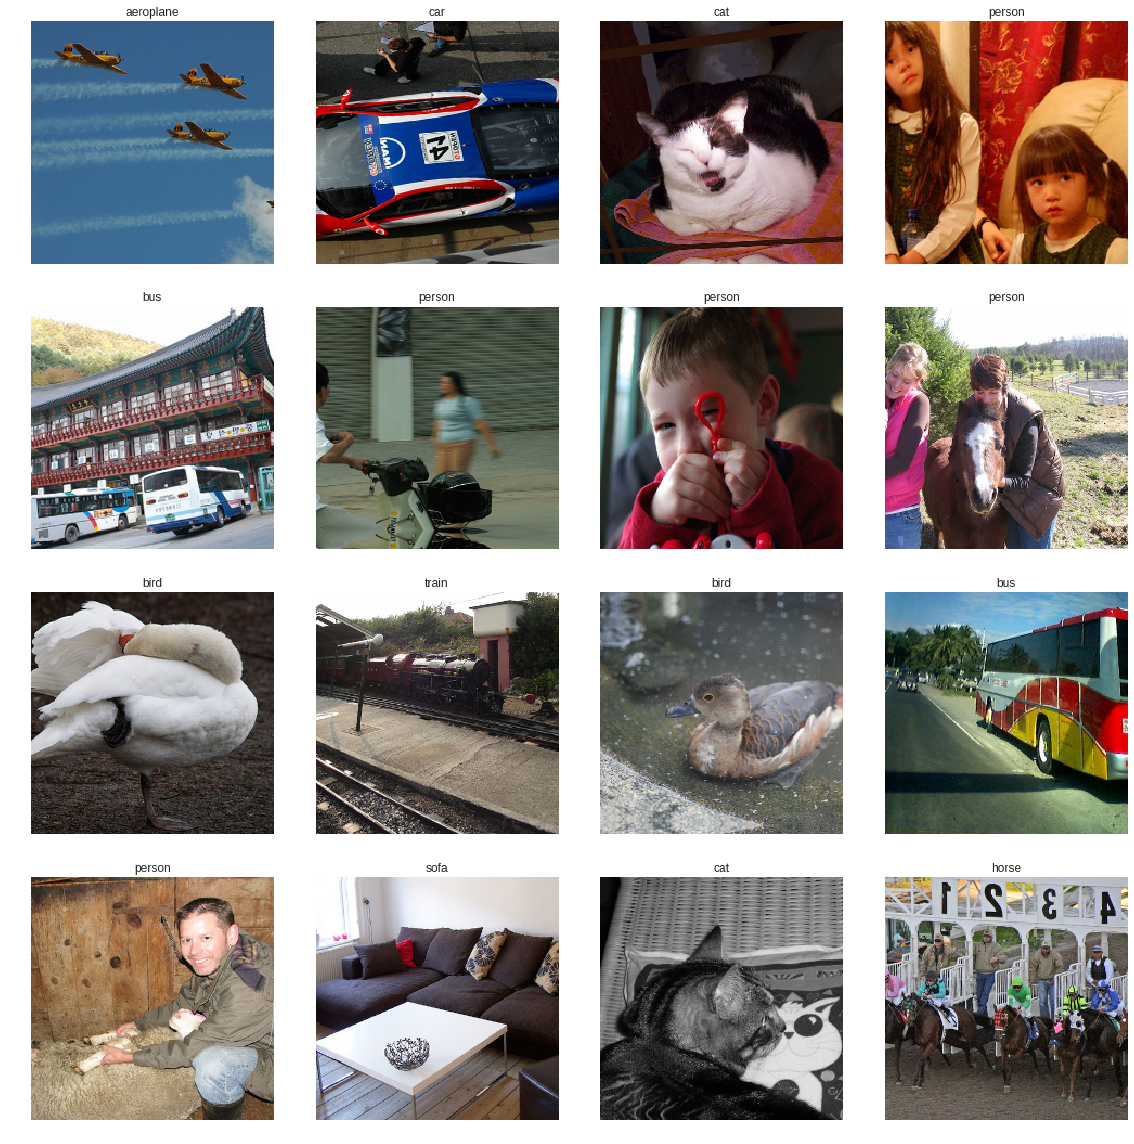

In [7]:
data.show_batch()

In [8]:
learner = create_cnn(data, models.resnet18, metrics=[accuracy])
learner.fit_one_cycle(5,1e-3)
learner.save('stage-1')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
46827520it [00:01, 24401883.19it/s]


epoch,train_loss,valid_loss,accuracy,time
1,2.828158,1.515512,0.612981,00:34
2,1.570570,0.944192,0.720353,00:33
3,1.117653,0.811882,0.755609,00:34
4,0.889762,0.809058,0.747596,00:33
5,0.783627,0.800683,0.758814,00:33


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


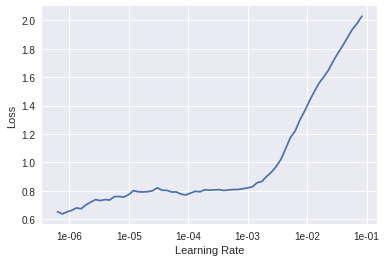

In [13]:
learner.load('stage-1')
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

In [14]:
learner.fit_one_cycle(5, max_lr=slice(1e-6,1e-4))
learner.save('stage-2')

epoch,train_loss,valid_loss,accuracy,time
1,0.772613,0.787494,0.766026,00:34
2,0.777963,0.783531,0.762019,00:35
3,0.714195,0.776179,0.763622,00:35
4,0.672106,0.767712,0.770833,00:34
5,0.658906,0.774743,0.770032,00:34


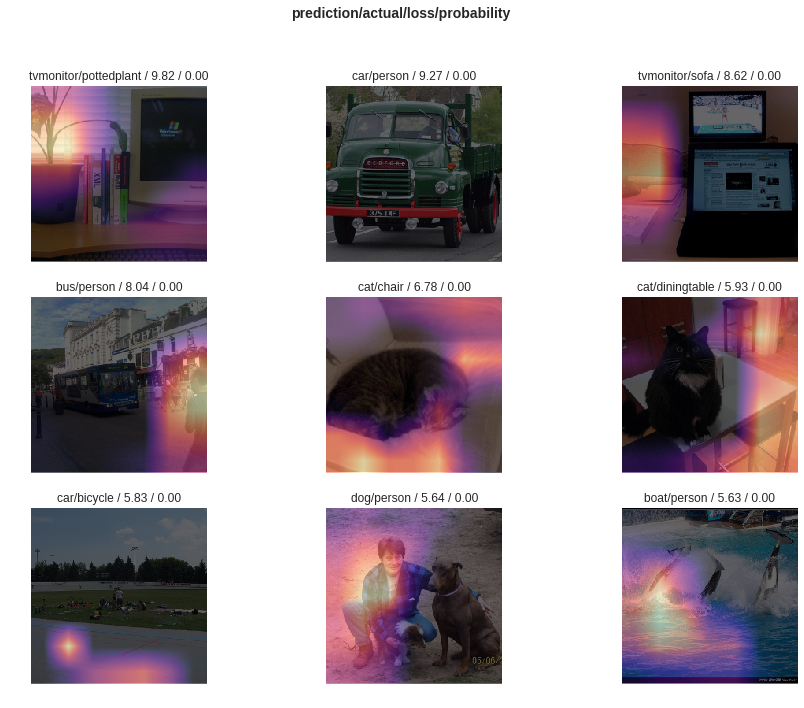

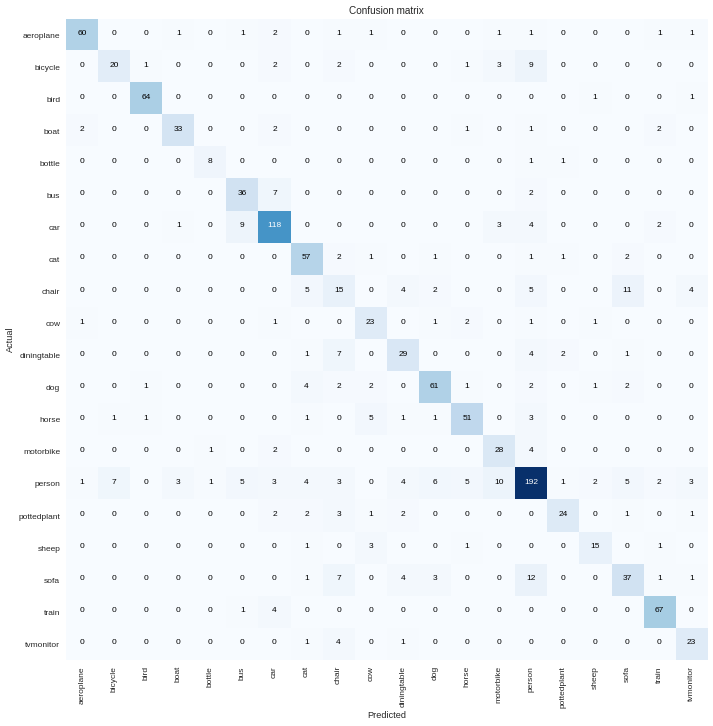

In [18]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(9, figsize=(15,11))
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
